# Загружаем датасет

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


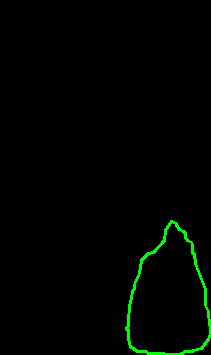

In [ ]:
import pickle
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

from google.colab import drive
drive.mount('/content/drive')

# скачаем набор данных с эталонными контурами
with open('/content/drive/MyDrive/Stones/URFU/Эталоны/standard.pkl', 'rb') as f:
  dataset_initial = pickle.load(f)

dataset = []
# сделаем все координаты целочисленными
for i in range(len(dataset_initial)):
  curr_contour = dataset_initial[i][0]
  curr_contour_round = [round(el) for el in curr_contour]
  x_points = [curr_contour_round[i] for i in range(len(curr_contour_round)) if i % 2 == 0]
  y_points = [curr_contour_round[i] for i in range(len(curr_contour_round)) if i % 2 == 1]
  points = []
  for point in zip(x_points, y_points):
    points.append(point)
  dataset.append(points)

def draw_polygon(vertices, color=(255, 255, 255), thickness=1, isClosed=False):
    # Создаем пустое изображение
    max_x = max(vertices, key=lambda x: x[0])[0]
    max_y = max(vertices, key=lambda x: x[1])[1]
    img = np.zeros((max_y + 1, max_x + 1, 3), dtype=np.uint8)

    # Преобразуем координаты вершин в массив numpy
    vertices = np.array(vertices, np.int32)

    # Изменяем форму массива вершин для функции cv2.polylines
    vertices = vertices.reshape((-1, 1, 2))

    # Рисуем фигуру на изображении
    cv2.polylines(img, [vertices], isClosed=isClosed, color=color, thickness=thickness)

    # Отображаем изображение
    cv2_imshow(img)
#    cv2.waitKey(0)
#    cv2.destroyAllWindows()

# Пример использования
color = (0, 255, 0)
thickness = 2

draw_polygon(dataset[1], color, thickness)

# Функция поворота и выравнивания

In [ ]:
def generate_freeman_code(vertices, isClosed=False):
    # Инициализация списка для хранения пикселей контура
    contour_pixels = []

    # Перебор пар соседних вершин
    for i in range(len(vertices) - 1):
        x1, y1 = vertices[i]
        x2, y2 = vertices[i + 1]

        # Генерация пикселей ребра с помощью алгоритма Брезенхэма
        dx = abs(x2 - x1)
        dy = abs(y2 - y1)
        sx = 1 if x1 < x2 else -1
        sy = 1 if y1 < y2 else -1
        err = dx - dy

        while True:
            contour_pixels.append((x1, y1))
            if x1 == x2 and y1 == y2:
                break
            e2 = 2 * err
            if e2 > -dy:
                err -= dy
                x1 += sx
            if e2 < dx:
                err += dx
                y1 += sy

    # Если контур должен быть замкнутым, добавляем последнюю вершину
    if isClosed:
        contour_pixels.append(vertices[-1])

    # Вычисление цепного кода Фримана
    freeman_code = []
    for i in range(1, len(contour_pixels)):
        dx = contour_pixels[i][0] - contour_pixels[i - 1][0]
        dy = contour_pixels[i][1] - contour_pixels[i - 1][1]

        if dx == 1 and dy == 0:
            freeman_code.append(0)
        elif dx == 1 and dy == 1:
            freeman_code.append(1)
        elif dx == 0 and dy == 1:
            freeman_code.append(2)
        elif dx == -1 and dy == 1:
            freeman_code.append(3)
        elif dx == -1 and dy == 0:
            freeman_code.append(4)
        elif dx == -1 and dy == -1:
            freeman_code.append(5)
        elif dx == 0 and dy == -1:
            freeman_code.append(6)
        elif dx == 1 and dy == -1:
            freeman_code.append(7)

    return freeman_code

# generate_freeman_code(dataset[129])

Поворот контура

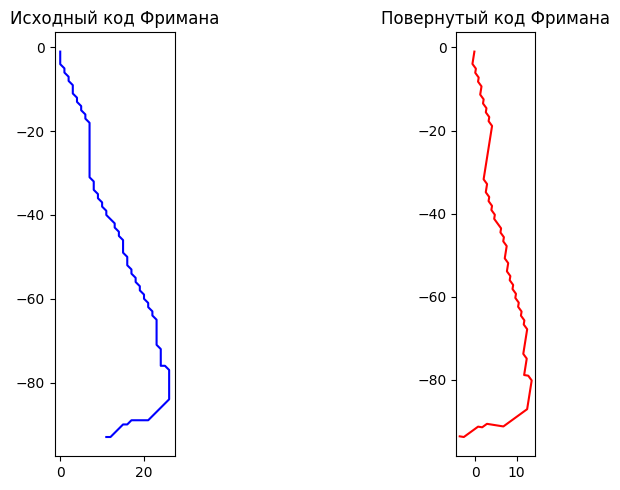

Повернутый код Фримана: [6, 6, 6, 7, 6, 7, 6, 7, 6, 6, 7, 6, 7, 6, 7, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 7, 6, 7, 6, 7, 6, 7, 7, 6, 7, 6, 7, 6, 6, 6, 7, 6, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 0, 7, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 4, 4, 4, 4, 5, 4, 5, 5, 5, 4]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def rotate_freeman_code(code_list, n):
    # Определение направлений для цепного кода Фримана
    directions = np.array([[1, 0], [1, 1], [0, 1], [-1, 1], [-1, 0], [-1, -1], [0, -1], [1, -1]])

    # Преобразование цепного кода в координаты
    coords = np.cumsum([directions[c] for c in code_list], axis=0)

    # Поворот координат на pi/n градусов
    angle = np.pi / n
    rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
    rotated_coords = np.dot(coords, rotation_matrix)

    # Вычисление повернутого цепного кода
    rotated_code = []
    for i in range(len(rotated_coords) - 1):
        diff = rotated_coords[i + 1] - rotated_coords[i]
        direction = np.argmin(np.sum((directions - diff) ** 2, axis=1))
        rotated_code.append(direction)

    # Визуализация исходного и повернутого кодов
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    ax1.plot(coords[:, 0], coords[:, 1], 'b-')
    ax1.set_title('Исходный код Фримана')
    ax1.set_aspect('equal')

    ax2.plot(rotated_coords[:, 0], rotated_coords[:, 1], 'r-')
    ax2.set_title('Повернутый код Фримана')
    ax2.set_aspect('equal')

    plt.tight_layout()
    plt.show()

    return rotated_code

vertices = dataset[129]
freeman_code = generate_freeman_code(vertices)[:100]
rotated_code = rotate_freeman_code(freeman_code, 20)
print('Повернутый код Фримана:', rotated_code)

Функция выравнивания

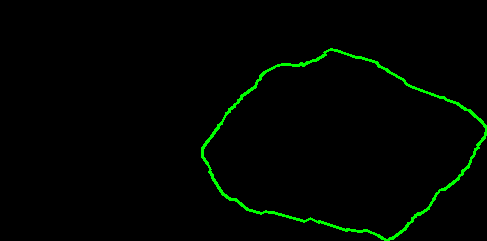

In [ ]:
def align_polygon(vertices):
    # Преобразуем последовательность вершин в массив NumPy
    vertices_array = np.array(vertices)

    # Находим вписанный эллипс минимальной площади
    ellipse = cv2.fitEllipse(vertices_array)

    # Извлекаем параметры эллипса
    center, axes, angle = ellipse

    # Создаем матрицу поворота
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

    # Поворачиваем вершины
    aligned_vertices = cv2.transform(vertices_array.reshape(-1, 1, 2), rotation_matrix).reshape(-1, 2)

    # Проверяем, нужно ли повернуть контур на 90 градусов
    if axes[0] < axes[1]:
        # Создаем матрицу поворота на 90 градусов
        rotation_matrix_90 = cv2.getRotationMatrix2D(center, 90, 1.0)

        # Поворачиваем вершины на 90 градусов
        aligned_vertices = cv2.transform(aligned_vertices.reshape(-1, 1, 2), rotation_matrix_90).reshape(-1, 2)

    # Округляем координаты до целых чисел
    aligned_vertices = np.round(aligned_vertices).astype(int)

    return aligned_vertices.tolist()

alligned_points = align_polygon(dataset[96])

draw_polygon(alligned_points, color, thickness, isClosed=False)

# CCEM

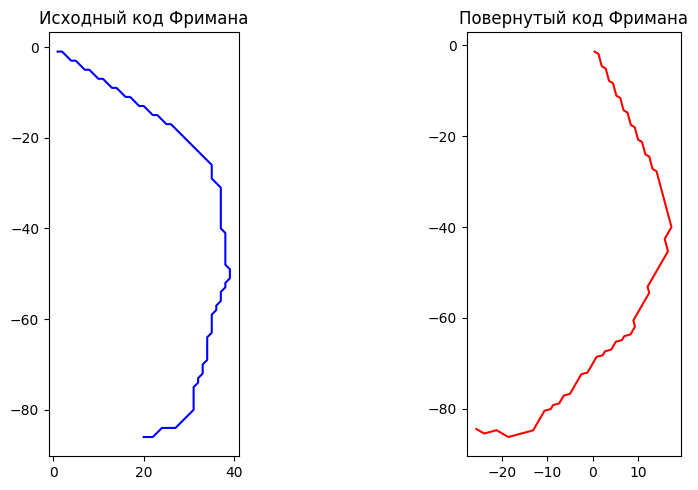

[0,
 6,
 6,
 0,
 6,
 6,
 0,
 6,
 6,
 0,
 6,
 6,
 0,
 6,
 6,
 0,
 6,
 6,
 0,
 6,
 6,
 0,
 6,
 6,
 0,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 5,
 5,
 6,
 6,
 6,
 5,
 6,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 6,
 5,
 5,
 5,
 5,
 5,
 5,
 6,
 6,
 5,
 5,
 4,
 5,
 4,
 5,
 6,
 4,
 5,
 4,
 5,
 6,
 6,
 6,
 4,
 5,
 5,
 5,
 5,
 5,
 4,
 5,
 5,
 4,
 5,
 4,
 5,
 5,
 5,
 5,
 5,
 4,
 4,
 4,
 4,
 3,
 3,
 3,
 4,
 4,
 3,
 3]

In [ ]:
# извлечем из контура подпоследовательность длины freeman_code
test_code = generate_freeman_code(dataset[0])[:len(freeman_code)]
rotate_freeman_code(test_code, 6)

In [ ]:
directions = np.array([[1, 0], [1, 1], [0, 1], [-1, 1], [-1, 0], [-1, -1], [0, -1], [1, -1]])
n = 18 # 10 градусов

code_list = test_code

# Преобразование цепного кода в координаты
coords = np.cumsum([directions[c] for c in code_list], axis=0)

# Поворот координат на pi/n градусов
angle = np.pi / n
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
rotated_coords = np.dot(coords, rotation_matrix)

# берем два цепных кода freeman_code, test_code (они одинаковой длины) и переводим в координаты
coords_F = np.cumsum([directions[c] for c in freeman_code], axis=0)
coords_C = np.cumsum([directions[c] for c in test_code], axis=0)

# вращаем код фрагмента вдоль кода контура на градус и находим расстояния
rotated_coords_list = []

for i in range(360):
  angle = i * np.pi / 180
  rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
  rotated_coords = np.dot(coords_F, rotation_matrix)
  rotated_coords_list.append(rotated_coords)

rotated_coords_list[0]

array([[  0.,  -1.],
       [  0.,  -2.],
       [  0.,  -3.],
       [  0.,  -4.],
       [  1.,  -5.],
       [  1.,  -6.],
       [  2.,  -7.],
       [  2.,  -8.],
       [  3.,  -9.],
       [  3., -10.],
       [  3., -11.],
       [  4., -12.],
       [  4., -13.],
       [  5., -14.],
       [  5., -15.],
       [  6., -16.],
       [  6., -17.],
       [  7., -18.],
       [  7., -19.],
       [  7., -20.],
       [  7., -21.],
       [  7., -22.],
       [  7., -23.],
       [  7., -24.],
       [  7., -25.],
       [  7., -26.],
       [  7., -27.],
       [  7., -28.],
       [  7., -29.],
       [  7., -30.],
       [  7., -31.],
       [  8., -32.],
       [  8., -33.],
       [  8., -34.],
       [  9., -35.],
       [  9., -36.],
       [ 10., -37.],
       [ 10., -38.],
       [ 11., -39.],
       [ 11., -40.],
       [ 12., -41.],
       [ 13., -42.],
       [ 13., -43.],
       [ 14., -44.],
       [ 14., -45.],
       [ 15., -46.],
       [ 15., -47.],
       [ 15.,

In [ ]:
# находим расстояния
coords_C_np = np.array(coords_C)
res = []

for i in range(len(rotated_coords_list)):
  diff_list_sum = np.sum((coords_C_np - np.array(rotated_coords_list[i]) ) ** 2)
  res.append([i, diff_list_sum])


In [ ]:
res[:10]

[[0, 30721.0],
 [1, 33579.57142717754],
 [2, 36640.01300298626],
 [3, 39901.39248727498],
 [4, 43362.71643225911],
 [5, 47022.930485134406],
 [6, 50880.91970924307],
 [7, 54935.50892369426],
 [8, 59185.46306133558],
 [9, 63629.48754496644]]

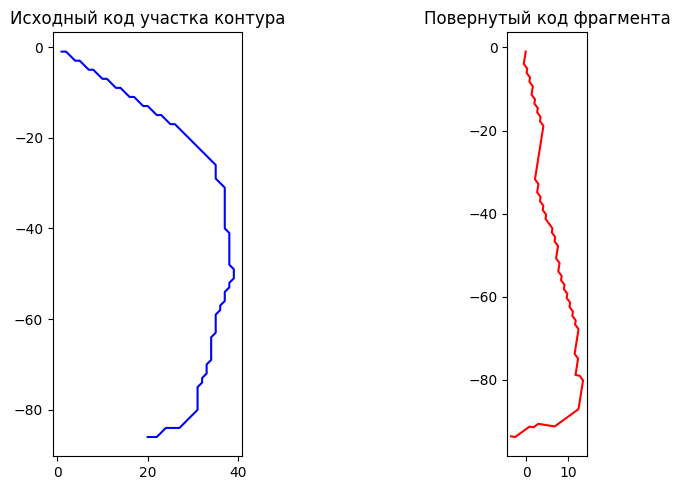

In [ ]:
# Визуализация исходного и повернутого кодов
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(coords_C[:, 0], coords_C[:, 1], 'b-')
ax1.set_title('Исходный код участка контура')
ax1.set_aspect('equal')

ax2.plot(rotated_coords_list[9][:, 0], rotated_coords_list[9][:, 1], 'r-')
ax2.set_title('Повернутый код фрагмента')
ax2.set_aspect('equal')

plt.tight_layout()
plt.show()

Соединим все в одну единую конструкцию:

1) Функция, находящая лучший поворот для фиксированного отреза контура

In [ ]:
def find_best_rotation(coords_F, coords_C):
  # создаем массив преобразованных координат
  rotated_coords_list = []

  # перебираем все повороты
  for i in range(360):
    angle = i * np.pi / 180
    rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
    rotated_coords = np.dot(coords_F, rotation_matrix)
    rotated_coords_list.append(rotated_coords)

  # находим расстояния
  coords_C_np = np.array(coords_C)
  res = []

  for i in range(len(rotated_coords_list)):
    diff_list_sum = np.sum((coords_C_np - np.array(rotated_coords_list[i]) ) ** 2)
    res.append(diff_list_sum)

  return min(res)

find_best_rotation(coords_F, coords_C)

12241.002391041107

2) Функция, генериующая все отрезы контура половинной длины

In [ ]:
freeman_code_С = generate_freeman_code(dataset[1])

def get_subsequences(numbers, length):
    n = len(numbers)
    result = []

    for start in range(n):
        subsequence = []
        for i in range(length):
            index = (start + i) % n
            subsequence.append(numbers[index])
        result.append(subsequence)

    return result

numbers = freeman_code_С # [1, 2, 3, 4]
length = len(freeman_code_С) // 2
subsequences = get_subsequences(numbers, length)
print(subsequences)

[[0, 0, 7, 0, 0, 0, 7, 0, 7, 7, 6, 7, 7, 7, 6, 7, 7, 6, 7, 6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 5, 6, 5, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 5, 6, 6, 5, 6, 6, 5, 6, 5, 6, 6, 5, 6, 5, 6, 6, 5, 6, 6, 5, 6, 5, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 4, 5, 4, 5, 5, 6, 5, 6, 6, 6, 6, 5, 5, 4, 5, 4, 5, 5, 6, 5, 5, 6, 6, 4, 5, 4, 5, 4, 3, 2, 3, 3, 2, 3, 3, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 3, 3, 3, 3, 2, 3], [0, 7, 0, 0, 0, 7, 0, 7, 7, 6, 7, 7, 7, 6, 7, 7, 6, 7, 6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 5, 6, 5, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 5, 6, 6, 5, 6, 6, 5, 6, 5, 6, 6, 5, 6, 5, 6, 6, 5, 6, 6, 5, 6, 5, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 4, 5, 4, 5, 5, 6, 5, 6, 6, 6, 6, 5, 5, 4, 5, 4, 5, 5, 6, 5, 5, 6, 6, 4, 5, 4, 5, 4, 3, 2, 3, 3, 2, 3, 3, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 3, 3, 3, 

3) Наконец, итоговая функция для рассчета CCEM

In [ ]:
freeman_code_С = generate_freeman_code(dataset[1])

subsequences = get_subsequences(freeman_code_С, length)

# Еще раз корректируем

In [ ]:
def distance(num_C, num_F):
  # массив направлений для создания ЦКФ
  directions = np.array([[1, 0], [1, 1], [0, 1], [-1, 1], [-1, 0], [-1, -1], [0, -1], [1, -1]])
  # сгенерируем код Фримана для контура и фрагмента
  freeman_code_С = generate_freeman_code(dataset[num_C])
  freeman_code_F = generate_freeman_code(dataset[num_F])
  length = len(freeman_code_F) // 2
  # отрезаем половину контура от фрагмента
  freeman_code_F = freeman_code_F[: length]
  # сгенериуем набор подпоследовательностей
  subsequences = get_subsequences(freeman_code_С, length)

  res = []

  for subseq in subsequences:
  # берем два цепных кода freeman_code, test_code (они одинаковой длины) и переводим в координаты
    coords_F = np.cumsum([directions[c] for c in freeman_code_F], axis=0)
    coords_C = np.cumsum([directions[c] for c in subseq], axis=0)
    res.append(find_best_rotation(coords_F, coords_C))
  return min(res)

distance(0, 1)

11469.37855047335

In [ ]:
def L_W(i):
  vertices = align_polygon(dataset[i])
  # находим максимум и минимум по х
  max_x = max(vertices, key=lambda x: x[0])[0]
  min_x = min(vertices, key=lambda x: x[0])[0]
  # находим максимум и минимум по у
  max_y = max(vertices, key=lambda x: x[1])[1]
  min_y = min(vertices, key=lambda x: x[1])[1]

  return max_x - min_x, max_y - min_y

L_W(0)

(123, 92)

In [ ]:
exp_res = []

for i in range(10): # len(dataset)):
  delta = abs(L_W(i)[0] - 123) + abs(L_W(i)[1] - 92)
  exp_res.append([delta, distance(0, i)])
  if i % 10 == 0: print(i)

0


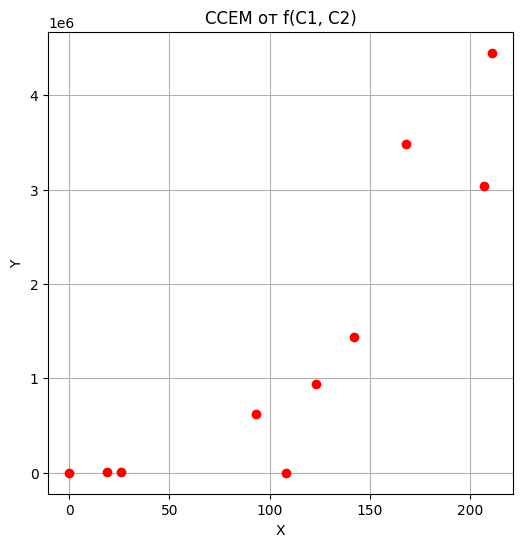

In [ ]:
import matplotlib.pyplot as plt

def plot_points(points):
    x = [point[0] for point in points]
    y = [point[1] for point in points]

    plt.figure(figsize=(6, 6))
    plt.plot(x, y, 'ro')

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('CCEM от f(C1, C2)')
    plt.grid(True)

    plt.show()

# Пример использования
plot_points(exp_res)

In [ ]:
import pandas as pd

df_corr = pd.DataFrame(exp_res, columns=['CCEM', 'F(C1, C2)'])
df_corr.corr()

,CCEM,"F(C1, C2)"
CCEM,1.000000,0.876332
"F(C1, C2)",0.876332,1.000000


# Финальные эксперименты

## До АСРК

Модифицируем функцию рассчета дистанций в зависимости от размера контура

In [ ]:
def distance(num_C, num_F, ratio):
  # массив направлений для создания ЦКФ
  directions = np.array([[1, 0], [1, 1], [0, 1], [-1, 1], [-1, 0], [-1, -1], [0, -1], [1, -1]])
  # сгенерируем код Фримана для контура и фрагмента
  freeman_code_С = generate_freeman_code(dataset[num_C])
  freeman_code_F = generate_freeman_code(dataset[num_F])
  length = round(len(freeman_code_F) * ratio)
  # отрезаем половину контура от фрагмента
  freeman_code_F = freeman_code_F[: length]
  # сгенериуем набор подпоследовательностей
  subsequences = get_subsequences(freeman_code_С, length)

  res = []

  for subseq in subsequences:
  # берем два цепных кода freeman_code, test_code (они одинаковой длины) и переводим в координаты
    coords_F = np.cumsum([directions[c] for c in freeman_code_F], axis=0)
    coords_C = np.cumsum([directions[c] for c in subseq], axis=0)
    res.append(find_best_rotation(coords_F, coords_C))
  return min(res)

distance(0, 1, 0.5)

11469.37855047335

Кластеризуем имеющийся набор данных

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def cluster_and_visualize(df, n_clusters):
    # Стандартизация данных
    scaler = StandardScaler()
    df = df[['L', 'W']]
    X = scaler.fit_transform(df)

    # Кластеризация с помощью k-means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(X)

    # Добавление меток кластеров к датафрейму
    df['cluster'] = labels

    # Визуализация результатов
    if df.shape[1] == 2:
        # Если в датафрейме 2 признака, строим scatter plot
        plt.scatter(df.iloc[:, 0], df.iloc[:, 1], c=labels)
        plt.title(f"K-Means Clustering (n_clusters={n_clusters})")
        plt.xlabel(df.columns[0])
        plt.ylabel(df.columns[1])
    elif df.shape[1] > 2:
        # Если в датафрейме больше 2 признаков, строим scatter plot для первых 2 признаков
        plt.scatter(df.iloc[:, 0], df.iloc[:, 1], c=labels)
        plt.title(f"K-Means Clustering (n_clusters={n_clusters})")
        plt.xlabel(df.columns[0])
        plt.ylabel(df.columns[1])
        print("Данные визуализированы для первых двух признаков.")
    else:
        print("В датафрейме должно быть минимум 2 признака для визуализации.")

    plt.show()
    return df

Данные визуализированы для первых двух признаков.


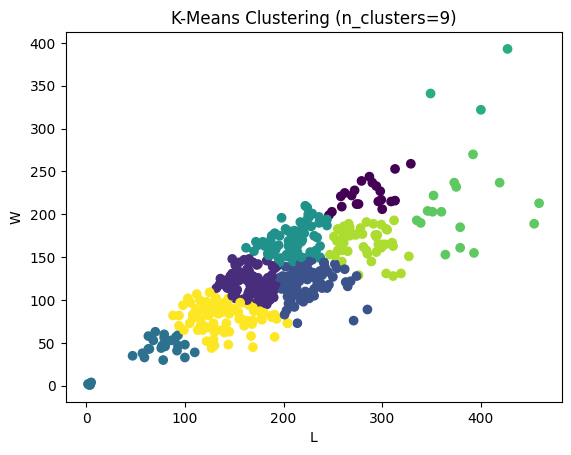

In [ ]:
data = pd.DataFrame([L_W(i) for i in range(len(dataset))], columns=['L', 'W'])
df_9 = cluster_and_visualize(data, n_clusters=9)

In [ ]:
df_9[df_9['L'] / df_9['W'] > 3]

,L,W,cluster
15,285,89,2
29,4,1,3
93,271,76,2
298,100,33,3
458,191,57,8
461,169,45,8


Будем выбирать наиболее подходящий кластер (минимальная дистанция)

In [ ]:
# prompt: напиши код, удаляющий из списка 406 элемент

dataset.pop(406)

[(494, 45), (493, 44), (492, 45), (493, 46), (494, 45)]

Напишем алгоритм реконструкции

Сформулируем 1000 случайных примеров с долей 0.9

In [ ]:
# prompt: напиши код, генерирующий список из 10 случайных целых числе от 0 до 463

import random

def generate_random_numbers():
  random_numbers = []
  for _ in range(30):
    random_numbers.append(random.randint(0, len(dataset_new)))
  return random_numbers

# print(generate_random_numbers())

a = generate_random_numbers()
b = generate_random_numbers()

print(sorted(a), sorted(b))

[3, 133, 160, 179, 254, 319, 338, 368, 398, 419, 425, 491, 518, 523, 551, 553, 557, 613, 664, 670, 686, 709, 810, 820, 840, 876, 888, 909, 916, 927] [19, 64, 89, 149, 242, 277, 342, 355, 404, 409, 429, 436, 459, 482, 502, 515, 518, 584, 654, 702, 747, 760, 764, 799, 806, 827, 829, 877, 952, 967]


In [ ]:
import time

arr = []

start_time = time.time()
# рассчитаем все расстояния до камней варьируя долю видимости камня
for i in a:
  # pd.DataFrame(arr, columns=['i', 'j', 'distance']).to_csv('/content/drive/MyDrive/Диссертация/01_dist_3.csv')
  for j in b:
    arr.append([i, j, distance(i, j, 0.9)])
    print(i, j)

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.6f} seconds")

In [ ]:
df_09 = pd.DataFrame(arr, columns=['i', 'j', 'distance'])
df_09

In [ ]:
# prompt: у нас есть датасет df_09 с номерами i и j камней и расстоянием между ними, а также датасет df_45 с кластерами камней, в нем номер камня - это индекс строки. Напиши код, который создает новый датафрейм, соединяя df_09 с df_45 , так чтобы были выведены длина L и ширина W для i и j камня, расстояние между ними и номера кластеров

# Assuming df_09 and df_45 are already defined as in your provided code.
del df_merged

data = pd.DataFrame([L_W(i) for i in range(len(dataset))], columns=['L', 'W'])
df_9 = cluster_and_visualize(data, n_clusters=9)
# Rename columns for clarity and merging
df_9 = df_9.rename(columns={'L': 'L_i', 'W': 'W_i', 'cluster': 'cluster_i'})

# Merge the dataframes
df_merged = pd.merge(df_09, df_9, left_on='i', right_index=True, how='left')

df_9 = df_9.rename(columns={'L_i': 'L_j', 'W_i': 'W_j', 'cluster_i': 'cluster_j'})

df_merged = pd.merge(df_merged, df_9, left_on='j', right_index=True, how='left')

# Display the resulting dataframe
df_merged #[['i', 'j', 'distance', 'L_i', 'W_i', 'cluster_i', 'L_j', 'W_j', 'cluster_j']]

In [ ]:
df_merged['F'] = abs( df_merged['L_i'] - df_merged['L_j'] ) + abs( df_merged['W_i'] - df_merged['W_j'])
df_merged = df_merged.sort_values(by='distance')
df_merged.head(10)

# После добавления лещадности

In [ ]:
# prompt: напиши код, загружающий pickle файл /content/drive/MyDrive/Stones/URFU/Эталоны/flaki_dataset.pickle в список

import pickle

with open('/content/drive/MyDrive/Stones/URFU/Эталоны/flaki_dataset.pickle', 'rb') as f:
  data = pickle.load(f)

print(type(data))
print(len(data))

<class 'list'>
510


In [ ]:
# len(dataset + data)
dataset_new = dataset + data

In [ ]:
def distance_new(num_C, num_F, ratio):
  # массив направлений для создания ЦКФ
  directions = np.array([[1, 0], [1, 1], [0, 1], [-1, 1], [-1, 0], [-1, -1], [0, -1], [1, -1]])
  # сгенерируем код Фримана для контура и фрагмента
  freeman_code_С = generate_freeman_code(dataset_new[num_C])
  freeman_code_F = generate_freeman_code(dataset_new[num_F])
  length = round(len(freeman_code_F) * ratio)
  # отрезаем половину контура от фрагмента
  freeman_code_F = freeman_code_F[: length]
  # сгенериуем набор подпоследовательностей
  subsequences = get_subsequences(freeman_code_С, length)

  res = []

  for subseq in subsequences:
  # берем два цепных кода freeman_code, test_code (они одинаковой длины) и переводим в координаты
    coords_F = np.cumsum([directions[c] for c in freeman_code_F], axis=0)
    coords_C = np.cumsum([directions[c] for c in subseq], axis=0)
    res.append(find_best_rotation(coords_F, coords_C))
  return min(res)

distance_new(0, 500, 0.5)

364210.1112534142

In [ ]:
import time

a = generate_random_numbers()
b = generate_random_numbers()

print(sorted(a), sorted(b))

arr = []

start_time = time.time()
# рассчитаем все расстояния до камней варьируя долю видимости камня
for i in a:
  # pd.DataFrame(arr, columns=['i', 'j', 'distance']).to_csv('/content/drive/MyDrive/Диссертация/01_dist_3.csv')
  for j in b:
    arr.append([i, j, distance_new(i, j, 0.7)])
    print(i, j)

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.6f} seconds")

[9, 51, 103, 104, 122, 240, 247, 279, 296, 296, 370, 497, 498, 544, 577, 611, 633, 635, 683, 699, 722, 743, 823, 855, 871, 878, 879, 908, 943, 948] [46, 62, 137, 192, 229, 239, 275, 458, 486, 493, 532, 562, 584, 589, 590, 590, 603, 609, 672, 697, 713, 735, 777, 785, 798, 899, 907, 921, 940, 952]
370 785
370 590
370 713
370 458
370 697
370 952
370 137
370 603
370 589
370 239
370 493
370 532
370 486


KeyboardInterrupt: 

In [ ]:
pd.DataFrame(arr, columns=['i', 'j', 'distance']).to_csv('/content/drive/MyDrive/Диссертация/dist_new.csv')

In [ ]:
df_dist = pd.read_csv('/content/drive/MyDrive/Диссертация/dist_new.csv', index_col=0)
df_dist

In [ ]:
def L_W_new(i):
  vertices = align_polygon(dataset_new[i])
  # находим максимум и минимум по х
  max_x = max(vertices, key=lambda x: x[0])[0]
  min_x = min(vertices, key=lambda x: x[0])[0]
  # находим максимум и минимум по у
  max_y = max(vertices, key=lambda x: x[1])[1]
  min_y = min(vertices, key=lambda x: x[1])[1]

  return max_x - min_x, max_y - min_y


# [L_W_new(i) for i in range(len(dataset_new))]

Данные визуализированы для первых двух признаков.


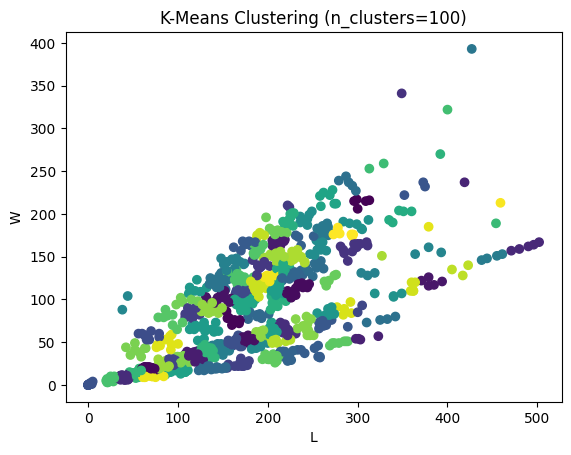

NameError: name 'df_dist' is not defined

In [ ]:
# prompt: у нас есть датасет df_09 с номерами i и j камней и расстоянием между ними, а также датасет df_45 с кластерами камней, в нем номер камня - это индекс строки. Напиши код, который создает новый датафрейм, соединяя df_09 с df_45 , так чтобы были выведены длина L и ширина W для i и j камня, расстояние между ними и номера кластеров

# Assuming df_09 and df_45 are already defined as in your provided code.
#del df_merged

data = pd.DataFrame([L_W_new(i) for i in range(len(dataset_new))], columns=['L', 'W'])
df_clusters_100 = cluster_and_visualize(data, n_clusters=100)
# Rename columns for clarity and merging
df_clusters_100 = df_clusters_100.rename(columns={'L': 'L_i', 'W': 'W_i', 'cluster': 'cluster_i'})

# Merge the dataframes
df_merged = pd.merge(df_dist, df_clusters_100, left_on='i', right_index=True, how='left')

df_clusters_100 = df_clusters_100.rename(columns={'L_i': 'L_j', 'W_i': 'W_j', 'cluster_i': 'cluster_j'})

df_merged = pd.merge(df_merged, df_clusters_100, left_on='j', right_index=True, how='left')

# Display the resulting dataframe
df_merged #[['i', 'j', 'distance', 'L_i', 'W_i', 'cluster_i', 'L_j', 'W_j', 'cluster_j']]

In [ ]:
df_merged['F'] = abs( df_merged['L_i'] - df_merged['L_j'] ) + abs( df_merged['W_i'] - df_merged['W_j'])
df_merged = df_merged.sort_values(by='distance')
df_merged.head(20)

NameError: name 'df_merged' is not defined

# Тестируем методику нахождения опорного кластера

Данные визуализированы для первых двух признаков.


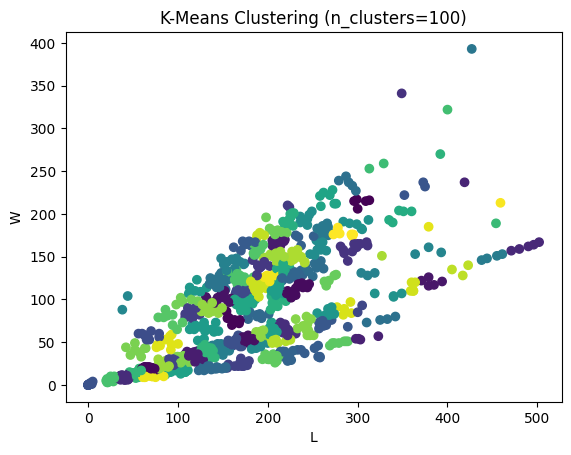

In [ ]:
data = pd.DataFrame([L_W_new(i) for i in range(len(dataset_new))], columns=['L', 'W'])
df_clusters_100 = cluster_and_visualize(data, n_clusters=100)

In [ ]:
df_clusters_100

,L,W,cluster
0,123,92,83
1,134,84,83
2,227,156,87
3,119,70,54
4,64,43,79
...,...,...,...
969,245,64,81
970,192,57,82
971,207,66,56
972,150,40,42


In [ ]:
# prompt: Используется DataFrame df_clusters_50: напиши код, который будет извлекать по 2 случаqных строки в каждом кластере cluster

import pandas as pd
import numpy as np

# Create an empty list to store the sampled data
sampled_rows = []

# Iterate through unique clusters
for cluster in df_clusters_100['cluster'].unique():
    # Filter data for the current cluster
    cluster_data = df_clusters_100[df_clusters_100['cluster'] == cluster]

    # Sample 2 rows randomly from the current cluster, handling cases where cluster has less than 2 rows
    n_samples = min(2, len(cluster_data))
    sampled_cluster = cluster_data.sample(n=n_samples)

    # Append sampled data to list
    sampled_rows.append(sampled_cluster)

# Concatenate the sampled data from all clusters
sampled_df = pd.concat(sampled_rows)

# Display the resulting DataFrame
sampled_df.sort_values(by='cluster')

,L,W,cluster
211,313,216,0
364,300,206,0
237,163,76,1
229,160,70,1
595,69,18,2
...,...,...,...
443,202,121,97
40,205,121,97
175,459,213,98
71,295,176,99


In [ ]:
index_list = sampled_df.index.to_list()
exp_arr = []

# 169, 150, 10

for i in index_list:
  print(i)
  exp_arr.append([20, i, distance_new(20, i, 0.9)])

0
134
2
410
160
78
468
455
418
451
52
150
40
443
405
151
431
125
10
362
438
186
808
407
14
645
696
63
416
439
396
25
380
349
323
49
449
424
100
309
264
136
269
179
28
858
38
148
249
154
172
119
142
408
39
42
276
71
101
401
47
50
217
382
192
226
384
99
325
61
228
66
67
331
94
73
270
318
287
379
441
84
164
85
91
238
207
561
93
413
461
542
478
365
332
124
757
126
342
132
346
244
175
316
459
367
294
206
211
364
642
787
390
252
804
516
237
229
258
876
321
274
511
277
648
685
825
599
327
683
917
664
828
879
907
944
502
537
949
513
717
507
694
725
595
739
591
891
524
477
732
735
952
900
771
569
806
558
942
676
960
945
490
582
871
548
497
957
646
499
584
520
724
526
951
621
765
626
758
690
860
611
941
713
628
822
702
720
866
764
815


In [ ]:
df_dist = pd.DataFrame(exp_arr, columns=['i', 'j', 'distance']).sort_values(by='distance')

Данные визуализированы для первых двух признаков.


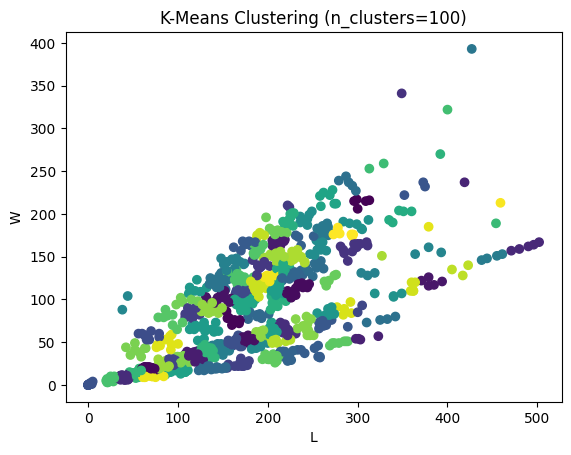

,i,j,distance,L_i,W_i,cluster_i,L_j,W_j,cluster_j
46,20,38,3.785786e+01,250,127,35,3,1,25
146,20,591,5.710290e+03,250,127,35,21,7,70
145,20,739,1.095056e+04,250,127,35,28,4,70
159,20,676,2.207595e+04,250,127,35,33,8,12
160,20,960,2.859549e+04,250,127,35,41,6,12
...,...,...,...,...,...,...,...,...,...
128,20,327,4.495556e+07,250,127,35,454,189,67
189,20,764,4.704206e+07,250,127,35,471,157,11
102,20,175,4.745323e+07,250,127,35,459,213,98
190,20,815,5.647319e+07,250,127,35,502,167,11


In [ ]:
# prompt: у нас есть датасет df_09 с номерами i и j камней и расстоянием между ними, а также датасет df_45 с кластерами камней, в нем номер камня - это индекс строки. Напиши код, который создает новый датафрейм, соединяя df_09 с df_45 , так чтобы были выведены длина L и ширина W для i и j камня, расстояние между ними и номера кластеров

# Assuming df_09 and df_45 are already defined as in your provided code.
del df_merged

data = pd.DataFrame([L_W_new(i) for i in range(len(dataset_new))], columns=['L', 'W'])
df_clusters_100 = cluster_and_visualize(data, n_clusters=100)
# Rename columns for clarity and merging
df_clusters_100 = df_clusters_100.rename(columns={'L': 'L_i', 'W': 'W_i', 'cluster': 'cluster_i'})

# Merge the dataframes
df_merged = pd.merge(df_dist, df_clusters_100, left_on='i', right_index=True, how='left')

df_clusters_100 = df_clusters_100.rename(columns={'L_i': 'L_j', 'W_i': 'W_j', 'cluster_i': 'cluster_j'})

df_merged = pd.merge(df_merged, df_clusters_100, left_on='j', right_index=True, how='left')

# Display the resulting dataframe
df_merged #[['i', 'j', 'distance', 'L_i', 'W_i', 'cluster_i', 'L_j', 'W_j', 'cluster_j']]

In [ ]:
df_merged['F'] = abs( df_merged['L_i'] - df_merged['L_j'] ) + abs( df_merged['W_i'] - df_merged['W_j'])
df_merged = df_merged[df_merged['W_j'] > 85].sort_values(by='distance', ascending=True)
df_merged.head(20)

,i,j,distance,L_i,W_i,cluster_i,L_j,W_j,cluster_j,F
16,20,431,44145.291422,250,127,35,216,125,32,36
17,20,125,44867.238678,250,127,35,239,129,32,13
60,20,47,51457.931338,250,127,35,202,139,16,60
75,20,73,59741.575366,250,127,35,234,118,3,25
52,20,142,63581.530068,250,127,35,225,135,60,33
80,20,441,96231.818283,250,127,35,181,121,91,75
76,20,270,105283.379333,250,127,35,231,113,3,33
20,20,438,118973.163178,250,127,35,211,109,55,57
21,20,186,132357.177530,250,127,35,212,116,55,49
51,20,119,133171.884524,250,127,35,212,135,60,46


# Эксперимент

Для проведения экспериментов будем действовать ледующим образом, отбираем случайный камень и вычисляем кластер с наименьшим расстоянием, а также фиксируем самые маленькие расстояния от фрагмента до кластера

In [ ]:
# prompt: сгенерируй случайную последовательность из 10 целых чисел от 0 до 973

import random

def generate_random_sequence(length, min_val, max_val):
  """Generates a random sequence of integers.

  Args:
    length: The length of the sequence.
    min_val: The minimum value for each integer.
    max_val: The maximum value for each integer.

  Returns:
    A list of random integers.
  """
  return [random.randint(min_val, max_val) for _ in range(length)]

# Generate a random sequence of 10 integers between 0 and 973
random_sequence = generate_random_sequence(10, 0, 973)
random_sequence

[536, 717, 801, 524, 900, 233, 121, 231, 800, 89]

In [ ]:
len(dataset_new)

974

In [ ]:
exp_arr_09 = []

for j in random_sequence:
  print(j)
  for i in index_list:
    exp_arr_09.append([j, i, distance_new(j, i, 0.9)])
    if len(exp_arr_09) % 20 == 0: print(len(exp_arr_09))


536
20
40
60
80
100
120
140
160
180
717
200
220
240
260
280
300
320
340
360
380
801
400
420
440
460
480
500
520
540
560
524
580
600
620
640
660
680
700
720
740
760
900


KeyboardInterrupt: 

Данные визуализированы для первых двух признаков.


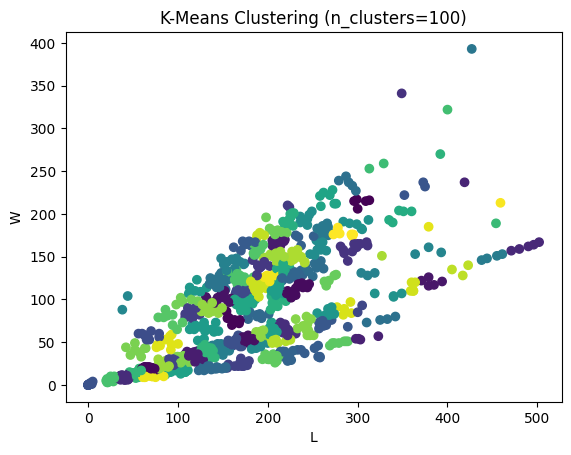

,i,j,distance,L_i,W_i,cluster_i,L_j,W_j,cluster_j
331,717,717,0.000000e+00,53,14,66,53,14,66
135,536,944,0.000000e+00,94,23,20,94,23,20
721,524,524,0.000000e+00,155,20,19,155,20,19
619,524,38,4.834871e+00,155,20,19,3,1,25
46,536,38,8.834871e+00,94,23,20,3,1,25
...,...,...,...,...,...,...,...,...,...
190,536,815,7.827480e+07,94,23,20,502,167,11
479,801,126,8.178766e+07,126,40,65,427,393,39
97,536,126,8.676490e+07,94,23,20,427,393,39
381,717,815,8.747484e+07,53,14,66,502,167,11


In [ ]:
del df_merged

df_dist = pd.DataFrame(exp_arr_09, columns=['i', 'j', 'distance']).sort_values(by='distance')

data = pd.DataFrame([L_W_new(i) for i in range(len(dataset_new))], columns=['L', 'W'])
df_clusters_100 = cluster_and_visualize(data, n_clusters=100)
# Rename columns for clarity and merging
df_clusters_100 = df_clusters_100.rename(columns={'L': 'L_i', 'W': 'W_i', 'cluster': 'cluster_i'})

# Merge the dataframes
df_merged = pd.merge(df_dist, df_clusters_100, left_on='i', right_index=True, how='left')

df_clusters_100 = df_clusters_100.rename(columns={'L_i': 'L_j', 'W_i': 'W_j', 'cluster_i': 'cluster_j'})

df_merged = pd.merge(df_merged, df_clusters_100, left_on='j', right_index=True, how='left')

# Display the resulting dataframe
df_merged #[['i', 'j', 'distance', 'L_i', 'W_i', 'cluster_i', 'L_j', 'W_j', 'cluster_j']]

In [ ]:
df_merged['F'] = abs( df_merged['L_i'] - df_merged['L_j'] ) + abs( df_merged['W_i'] - df_merged['W_j'])
#df_merged = df_merged[(df_merged['W_j'] > 85) & (df_merged['i'] == 175)].sort_values(by='distance')
df_merged[(df_merged['W_j'] > 85)].sort_values(by='distance').head(20)

In [ ]:
df_dist['j'].value_counts()